In [37]:
import numpy as np
from py_pol.jones_matrix import Jones_matrix
from py_pol.jones_vector import Jones_vector
from py_pol.mueller import Mueller

from py_pol import degrees

import matplotlib.pyplot as plt

from py_aocg.SLM_system import cargar_Jones_SLM, SLM_system_field
from py_aocg.ifta.algorithms import distances_scalar


import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx
from pyswarms.single.global_best import GlobalBestPSO
from pyswarms.single.local_best import LocalBestPSO
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
from pyswarms.utils.plotters.formatters import Mesher

## Cargar Matrices de polarización de Holoeye

In [38]:
S_incident=Jones_vector('incident')
S_incident.circular_light(intensity=2)

Jslm=cargar_Jones_SLM(type="Jones")

In [39]:
size_x_DOE, size_y_DOE = 15,15
doe_real = np.linspace(-1,1, size_x_DOE)
doe_imag = np.linspace(-1,1, size_y_DOE)

DOE_real, DOE_imag = np.meshgrid(doe_real, doe_imag)

DOE = DOE_real + 1j*DOE_imag

In [40]:
def cost_function_distances(angles, Jslm, S_incident):
    """ Cost function to obtain a properly SLM phase configuration 
    
    Args:
        angles: (np.ndarray): Rotation angles of P1, Q1, Q2 and P2.
        Jslm: (Jones_matrix): Jones matrix of the SLM.
        S_incident (Jones_vector): Illumination
        
    Returns:
        cost: (float): Value of merit function of a SLM phase configuration
        
    """

    u_fab_amplitude, u_fab_phase, fields=SLM_system_field(angles, Jslm, E0=S_incident)

    # Normalizar
    # u_fab_amplitude = u_fab_amplitude / u_fab_amplitude.max()
    u_fab = u_fab_amplitude*np.exp(1j*2*u_fab_phase)
    u_fab_real =u_fab[::5].real
    u_fab_imag =u_fab[::5].imag
    
    DOE_new, i_positions, distances=distances_scalar(DOE, u_fab)
    
    cost = distances.mean()
    # cost = np.linalg.norm(distances)
    
    return cost

In [41]:
def optimization_loop(angles,Jslm, S_incident, optimize_function):
    """
    Optimization loop of the particules of PySwarms algorithm.
    
    Args:
        angles: (np.ndarray): Rotation angles of P1, Q1, Q2 and P2.
        Jslm: (Jones_matrix): Jones matrix of the SLM.
        optimize_function (function): Function to optimize.
    
    Returns:
        cost: (float): Value of merit function
    
    """
    num_particles = angles.shape[0]
    cost = [cost_function_distances(angles[i,:],Jslm, S_incident) for i in range(num_particles)]
    
    return cost

In [42]:
Jslm = cargar_Jones_SLM()
print(Jslm.shape)

[256]


In [46]:
options = {'c1': 0.5, 'c2': 0.6, 'w': 0.9}
# options = {'c1': 0.5, 'c2': 0.5, 'w': 0.5}
dimensions = 4
min_bound = np.zeros(dimensions); max_bound = np.ones(dimensions)*360*degrees
bounds = (min_bound, max_bound)

iters=70
n_particles=70

In [47]:
optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=dimensions, options=options, bounds=bounds)

In [48]:
%%time 
cost, angles = optimizer.optimize(optimization_loop,iters,Jslm=Jslm, S_incident=S_incident ,optimize_function=cost_function_distances)

2023-01-30 15:36:26,336 - pyswarms.single.global_best - INFO - Optimize for 70 iters with {'c1': 0.5, 'c2': 0.6, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|70/70, best_cost=0.14 
2023-01-30 15:39:34,307 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.14009752934564795, best pos: [1.5648987  4.81839638 4.57774005 1.52924952]


CPU times: total: 3min 3s
Wall time: 3min 8s


In [49]:
print(angles/degrees)
#angles = np.array([0.85421954, 2.13133493, 4.81888539, 4.7449518 ])

[ 89.66209077 276.07377661 262.28518474  87.61954339]


- fase:       best cost: 0.21199592361665928, best pos: [1.63644037 5.11863528 2.7111866  1.68529409]
- amplitud    best cost: 0.21164481754171188, best pos: [1.61038889 1.947723   2.66072842 4.8141105 ]
- espiral:    best cost: 0.1860612974896374, best pos: [0.85421954 2.13133493 4.81888539 4.7449518 ]

In [50]:
 u_fab_amplitude, u_fab_phase, fields=SLM_system_field(angles, Jslm, E0=S_incident)

In [55]:
# Normalizar
# u_fab_amplitude = u_fab_amplitude / u_fab_amplitude.max()
u_fab = u_fab_amplitude*np.exp(1j*2*u_fab_phase)
u_fab_real =u_fab.real
u_fab_imag =u_fab.imag

DOE_new, i_positions, distances=distances_scalar(DOE, u_fab)
print(i_positions)

[[ 65  55  63  59  54  52  50  60  46  47  44  43  43  42  41]
 [ 62  65  55  61  57  53  50  60  46  47  44  43  42  41  40]
 [ 62  62  65  55  59  54 235 227 226  44  43  42  42  40  40]
 [ 69  69  62  65 240 238 235 234 226 222 220  42  40  40  38]
 [ 68  70  69 244 244 240 241 234 230 222 224 218  38  38  37]
 [ 79  79  76 244 244 255 255 241 230 225 225 219 209  35  35]
 [ 83  80  80 243 245 245 255 255 254 254 217 217 207  36  36]
 [ 84  84  84 247 247 247 248 254 254 254 254 205 197   0  34]
 [ 88  88 100 248 248 248 250 251 253 253 254 204 191  29  33]
 [ 90  95 110 248 249 249 250 251 253 253 253 189 184  28  27]
 [ 98 101 106 112 249 250 252 251 251 253 178 179 174  26  26]
 [ 91  91 112 111 125 252 252 251 165 176 176 167  10  24  24]
 [ 91 103 109 108 125 127 128 141 147 165 156   9  13  10  23]
 [103 109 108 117 118 127 129 141 142 148  18   5   6   8  22]
 [105 108 108 117 113 119 129 133 137 144  18   1   7   6   8]]


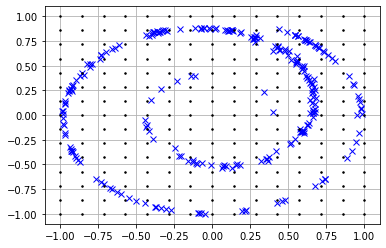

In [56]:
plt.figure()
plt.plot(u_fab_real, u_fab_imag, 'bx', ms=6)
plt.plot(DOE_real, DOE_imag, 'k.', ms=3)
plt.grid(True)